In [1]:
# imports
from __future__ import annotations

import contextlib
from typing import Any

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps
from rl.actor_critic import Actor, ActorCritic, Critic
from rl.network import GINPolicyNetwork, GINValueNetwork
from rl.utils import to_graph

from mcerl.env import Env
from mcerl.utils import (
    delta_time_reward_standardize,
    exploration_reward_rescale,
    multi_threaded_rollout,
    reward_sum,
    single_env_rollout,  # noqa: F401
)

%env SPDLOG_LEVEL=warning
%matplotlib inline

env: SPDLOG_LEVEL=warning


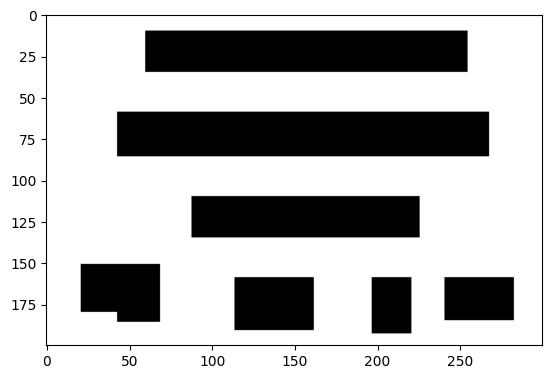

In [2]:
# load map
img = Image.open("0.png")
img = ImageOps.grayscale(img)
img = img.resize((300, 200))
grid_map = np.array(img)
grid_map[grid_map < 100] = 0
grid_map[grid_map >= 100] = 255
plt.imshow(grid_map, cmap="gray", vmin=0, vmax=255)

In [3]:
# define parameters
from math import pi

num_agents = 3
agent_poses = None
num_rays = 32
max_steps = 100000
max_steps_per_agent = 100
ray_range = 30
velocity = 1
min_frontier_size = 8
max_frontier_size = 30
exploration_threshold = 0.98
map_height, map_width = grid_map.shape
max_step_exploration_reward = ray_range * 2 * 1.41
max_exploration_gain = ray_range**2 * pi / 2.0
max_step_exploration_reward, max_exploration_gain

(84.6, 1413.7166941154069)

In [4]:
# create environment
env = Env(
    num_agents=num_agents,
    max_steps=max_steps,
    max_steps_per_agent=max_steps_per_agent,
    velocity=velocity,
    sensor_range=ray_range,
    num_rays=num_rays,
    min_frontier_pixel=min_frontier_size,
    max_frontier_pixel=max_frontier_size,
    exploration_threshold=exploration_threshold,
)

def env_transform(frame_data: dict[str, Any]) -> dict[str, Any]:
    """
    normalize position, exploration gain,etc.
    """
    # normalize frontier position to [0,1] and exploration gain to [0,1]
    width = float(map_width)
    height = float(map_height)
    frame_data["observation"]["frontier_points"] = [
        (
            float(x) / width,
            float(y) / height,
            float(gain) / max_exploration_gain,
        )
        for x, y, gain in frame_data["observation"]["frontier_points"]
    ]
    # normalize position to [0,1]
    frame_data["observation"]["pos"] = [
        (float(x) / width, float(y) / height)
        for x, y in frame_data["observation"]["pos"]
    ]
    frame_data["observation"]["target_pos"] = [
        (float(x) / width, float(y) / height)
        for x, y in frame_data["observation"]["target_pos"]
    ]
    # build graph
    # with contextlib.suppress(Exception):
    frame_data = to_graph(frame_data)
    return frame_data
# Example usage
# num_threads = 15
# epochs = 10
# rollouts = multi_threaded_rollout(
#     env=lambda: Env(
#         num_agents=num_agents,
#         max_steps=max_steps,
#         max_steps_per_agent=max_steps_per_agent,
#         velocity=velocity,
#         sensor_range=ray_range,
#         num_rays=num_rays,
#         min_frontier_pixel=min_frontier_size,
#         max_frontier_pixel=max_frontier_size,
#     ),
#     grid_map=grid_map,
#     agent_poses=agent_poses,
#     policy=policy,
#     num_threads=num_threads,
#     epochs=epochs,
# )
# trajectories = []
# frame_data = env.reset(grid_map, agent_poses, return_maps=True)
# trajectories.append(frame_data)
# while True:
#     agent_id = frame_data["info"]["agent_id"]
#     frame_data["action_agent_id"] = agent_id
#     frame_data = random_policy(frame_data)
#     frame_data = env.step(frame_data, return_maps=True)
#     trajectories.append(frame_data)
#     if env.done() is True:
#         break
# rollouts = split_trajectories(trajectories)
# rollouts = [pad_trajectory(rollout) for rollout in rollouts]
# rollouts = [refine_trajectory(rollout) for rollout in rollouts]

In [5]:
# define policy

policy_network = GINPolicyNetwork(dim_h=32)
value_network = GINValueNetwork(dim_h=32)

actor = Actor(policy_network=policy_network)
critic = Critic(value_network=value_network)
wrapped_actor_critic = ActorCritic(actor=actor, critic=critic)

/home/developer/mcerl/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
# get data
# single-threaded rollout

single_rollouts = single_env_rollout(env, grid_map, policy=wrapped_actor_critic,env_transform=env_transform)
rollouts=single_rollouts

# multi-threaded rollout
# num_threads = 20
# epochs = 100
# rollouts = multi_threaded_rollout(
#     env=lambda: Env(
#         num_agents=num_agents,
#         max_steps=max_steps,
#         max_steps_per_agent=max_steps_per_agent,
#         velocity=velocity,
#         sensor_range=ray_range,
#         num_rays=num_rays,
#         min_frontier_pixel=min_frontier_size,
#         max_frontier_pixel=max_frontier_size,
#     ),
#     grid_map=grid_map,
#     agent_poses=agent_poses,
#     policy=actor,
#     num_threads=num_threads,
#     epochs=epochs,
#     return_maps=False,
# )

exploration reward:


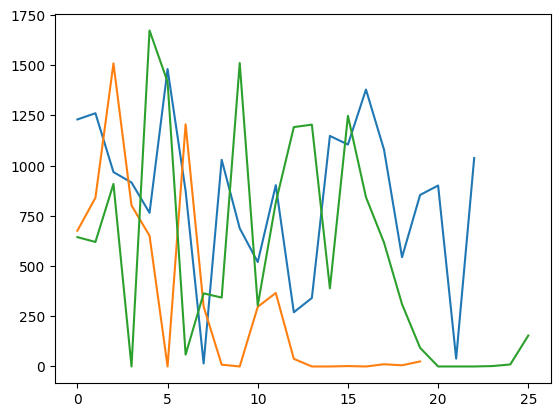

time_step_reward :


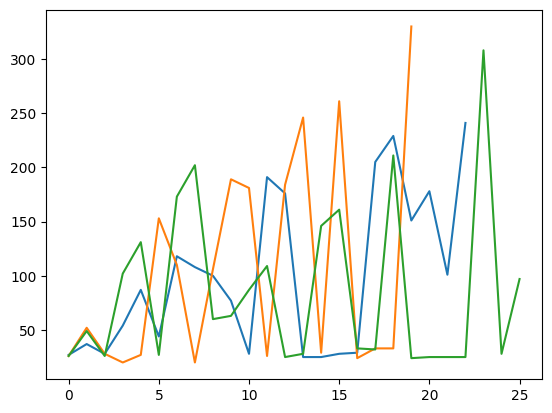

In [7]:
# draw raw rewards for debugging

print("exploration reward:")
for rollout in rollouts:
    plt.plot(
        [frame_data["next"]["reward"]["exploration_reward"] for frame_data in rollout]
    )
plt.show()
print("time_step_reward :")
for rollout in rollouts:
    plt.plot(
        [frame_data["next"]["reward"]["time_step_reward"] for frame_data in rollout]
    )
plt.show()

In [8]:
# normalize rewards
rollouts = [
    exploration_reward_rescale(rollout, max_value=max_exploration_gain)
    for rollout in rollouts
]
rollouts = [delta_time_reward_standardize(rollout) for rollout in rollouts]
rollouts = [reward_sum(rollout) for rollout in rollouts]

In [9]:
# compute GAE
from rl.actor_critic import GAE

lmbda = 0.95
gamma = 0.99
gae = GAE(gamma=gamma, lmbda=lmbda)
rollouts = [gae(rollout) for rollout in rollouts]

RuntimeError: The size of tensor a (9) must match the size of tensor b (10) at non-singleton dimension 0

In [ ]:
# draw normalized rewards for debugging
# total_reward
for rollout in rollouts:
    plt.plot([frame_data["next"]["reward"]["total_reward"] for frame_data in rollout])
mean_val = np.mean(
    [
        frame_data["next"]["reward"]["total_reward"]
        for frame_data in rollout
        for rollout in rollouts
    ]
)
plt.title(f"total reward:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")
plt.show()


# exploration_reward
for rollout in rollouts:
    plt.plot(
        [frame_data["next"]["reward"]["exploration_reward"] for frame_data in rollout]
    )
mean_val = np.mean(
    [
        frame_data["next"]["reward"]["exploration_reward"]
        for frame_data in rollout
        for rollout in rollouts
    ]
)
plt.title(f"exploration reward:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")
plt.show()

# time_step_reward
for rollout in rollouts:
    plt.plot(
        [frame_data["next"]["reward"]["time_step_reward"] for frame_data in rollout]
    )
mean_val = np.mean(
    [
        frame_data["next"]["reward"]["time_step_reward"]
        for frame_data in rollout
        for rollout in rollouts
    ]
)
plt.title(f"time step reward:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")
plt.show()

# reward_to_go
for rollout in rollouts:
    plt.plot([frame_data["reward_to_go"] for frame_data in rollout])
mean_val = np.mean(
    [frame_data["reward_to_go"] for frame_data in rollout for rollout in rollouts]
)
plt.title(f"reward to go:{mean_val}")
plt.axhline(mean_val, color="r", linestyle="--")
plt.show()


# reward_mean
reward_mean = [
    np.mean([frame_data["reward_to_go"] for frame_data in rollout])
    for rollout in rollouts
]
plt.plot(reward_mean)
plt.title(f"reward mean:{np.mean(reward_mean)}")
plt.axhline(y=np.mean(reward_mean), color="r", linestyle="--")
plt.show()

In [10]:
# store maps to gif
# rollouts=single_rollouts
# for rollout in rollouts:
#     agent_id = rollout[0]["info"]["agent_id"]
#     imgs = [
#         Image.fromarray(frame_data["observation"]["agent_map"])
#         for frame_data in rollout
#     ]
#     imgs[0].save(
#         f"agent_{agent_id}.gif",
#         save_all=True,
#         append_images=imgs[1:],
#         duration=100,
#         loop=0,
#     )
# flattened_rollouts = []
# for rollout in rollouts:
#     flattened_rollouts.extend(rollout)
# sorted_rollouts = sorted(flattened_rollouts, key=lambda x: x["info"]["step_cnt"])
# imgs = [
#     Image.fromarray(frame_data["observation"]["global_map"])
#     for frame_data in sorted_rollouts
# ]
# imgs[0].save(
#     "global_map.gif",
#     save_all=True,
#     append_images=imgs[1:],
#     duration=100,
#     loop=0,
# )

In [11]:
def check_dict_struct(d: dict[str, Any], prefix: str = "") -> list:
    flattened_keys = []
    for k, v in d.items():
        if isinstance(v, dict):
            flattened_keys.extend(check_dict_struct(v, prefix + k + "."))
        else:
            flattened_keys.append(prefix + k)
    return flattened_keys


In [ ]:
critic(rollouts[0][0])